In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from pathlib import Path
from ipywidgets import interact
from IPython.display import display
import pickle
import json

plt.rcParams["figure.figsize"] = (15,6)

In [ ]:
!unzip MNIST_WITHOUT_BN.zip

Archive:  MNIST_WITHOUT_BN.zip
  inflating: MNIST-logits-L2-without_BN_test.csv  
  inflating: MNIST-logits-L2-without_BN_train.csv  
  inflating: MNIST-logits-L2-without_BN_val.csv  


In [ ]:
model_name = "MNIST-logits-L2-without_BN"
stage = 'train'

df = pd.read_csv(f'{model_name}_{stage}.csv')

cls = 1

df_cls = df.loc[ df['y'] == cls ].copy()

df_cls.shape

(6017, 41)

In [ ]:
y = df_cls['y']
df_cls.drop('y', axis=1, inplace=True)

scaler = StandardScaler()

df_cls_scaled = pd.DataFrame( scaler.fit_transform(df_cls), columns=df_cls.columns)

In [ ]:
# Scaled
pca_cls = PCA()
df_cls_scaled_pca = pd.DataFrame( pca_cls.fit_transform(df_cls_scaled),
                                 columns=[f'PC_{i}' for i in range(df_cls_scaled.shape[1])] )

df_cls_scaled_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37,PC_38,PC_39
0,1.618385,-3.830934,2.546620,1.344173,-1.494557,-0.858854,-0.398678,0.783921,0.894053,-0.536961,...,0.064682,0.356636,-0.294057,-0.003318,-0.005052,0.033607,0.238235,0.073116,0.161771,-0.257182
1,-1.472220,3.096028,4.069902,4.531387,-3.565890,3.484435,-1.601967,-0.965542,0.144256,1.298515,...,0.281472,0.769284,-0.551966,0.117480,0.551106,-0.510181,0.610400,0.386591,-0.263265,0.075574
2,5.931209,10.069716,4.776077,8.554013,-4.278206,0.417395,3.335996,1.999668,-2.398122,-0.701691,...,-0.401447,0.111362,-0.375413,-0.648705,0.717067,0.040778,0.327598,0.264462,0.487554,-0.363016
3,-0.263525,0.474573,-1.926078,-1.157672,0.604931,0.367694,-1.398267,-0.127589,-0.767995,-1.100178,...,0.161532,-0.621592,0.213605,0.377107,0.072190,0.542109,-0.018333,-0.062943,-0.176733,0.162671
4,0.170672,-0.734274,4.181681,0.363538,1.053187,-2.465559,0.343103,-0.675558,-0.926329,-1.349096,...,-0.361489,0.425142,-0.170822,-0.114071,-0.266496,0.397448,-0.195530,0.049499,0.248659,-0.086852


Analysis

In [ ]:
var_df = pd.DataFrame({
    'x': [f'x{i}' for i in range(df_cls_scaled.shape[1])],
    'variance':pca_cls.explained_variance_,
    'variance_ratio':pca_cls.explained_variance_ratio_ * 100,
    'cum_variance': np.cumsum(pca_cls.explained_variance_ratio_ * 100),
    'singular_values': pca_cls.singular_values_
}).round(2)

var_df.loc[var_df['cum_variance'] <= 91]

,x,variance,variance_ratio,cum_variance,singular_values
0,x0,5.77,14.41,14.41,186.24
1,x1,5.17,12.91,27.32,176.28
2,x2,4.01,10.02,37.34,155.27
3,x3,3.55,8.88,46.22,146.18
4,x4,2.85,7.13,53.35,131.02
5,x5,2.60,6.51,59.86,125.18
6,x6,2.09,5.24,65.10,112.25
7,x7,1.77,4.42,69.51,103.11
8,x8,1.34,3.34,72.85,89.64
9,x9,1.14,2.85,75.70,82.88


In [ ]:
def num_component_fn(v_thld=90.0):
    return var_df[ var_df['cum_variance'].round(2) <= v_thld ].shape[0]

v_thld_val = interact(num_component_fn, v_thld=(0,100.05,0.05) )

interactive(children=(FloatSlider(value=90.0, description='v_thld', max=100.05, step=0.05), Output()), _dom_cl…

In [ ]:
num_component = num_component_fn(v_thld_val.widget.kwargs['v_thld']) + 1

In [ ]:
pca_component = pd.DataFrame( pca_cls.components_[:,:num_component],
                            columns=[f'PC_{i}' for i in range(num_component)],
                            index=[f'x{i}' for i in range(df_cls_scaled.shape[1])])

pca_component[:2]

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19
x0,0.157576,-0.164011,-0.101436,-0.013752,-0.347742,-0.177185,0.297078,0.206914,-0.010791,0.027420,0.093316,0.067154,0.116164,0.112570,0.274701,-0.207429,-0.187163,-0.310213,0.126019,0.134700
x1,-0.143318,-0.104884,0.006556,-0.185097,-0.055261,0.183792,-0.097942,-0.067518,0.171159,-0.137136,-0.094162,-0.004309,-0.177187,0.077691,-0.107534,-0.166400,-0.168177,0.123257,0.214873,0.250139


In [ ]:
pca_component.shape

(40, 20)

In [ ]:
pca_cls_loading = pca_component.multiply( np.sqrt(pca_cls.explained_variance_) , axis=0)

In [ ]:
pca_cls_loading[:2]

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19
x0,0.378359,-0.393810,-0.243559,-0.033020,-0.834970,-0.425442,0.713320,0.496823,-0.025910,0.065837,0.224063,0.161245,0.278922,0.270294,0.659588,-0.498061,-0.449399,-0.744857,0.302587,0.323430
x1,-0.325723,-0.238373,0.014900,-0.420677,-0.125595,0.417712,-0.222597,-0.153450,0.388999,-0.311674,-0.214005,-0.009793,-0.402698,0.176572,-0.244397,-0.378183,-0.382221,0.280132,0.488350,0.568499


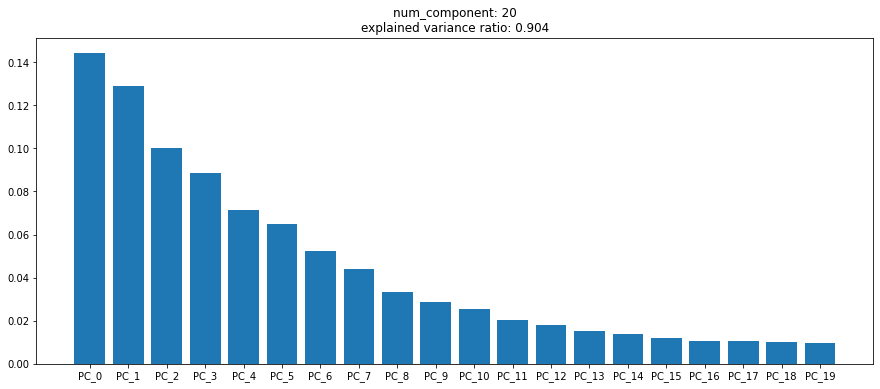

In [ ]:
plt.bar(pca_cls_loading.columns, pca_cls.explained_variance_ratio_[:num_component])
plt.xticks(pca_cls_loading.columns)
plt.title(f'''num_component: {num_component}
explained variance ratio: {pca_cls.explained_variance_ratio_[:num_component].sum().round(3)}''')
plt.show()

In [ ]:
def make_bar(col='PC_0'):
    plt.bar(pca_cls_loading.index, pca_cls_loading[col])
    plt.yticks(np.arange(-1,1.1, 0.1))
    plt.xticks(pca_cls_loading.index)
    plt.grid(axis='y')
    plt.title(f'neurons correlation against {col}')
    
display( 
    interact(
        make_bar,
        col=pca_cls_loading.columns
    )
)

interactive(children=(Dropdown(description='col', options=('PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC…

<function __main__.make_bar(col='PC_0')>

# Functions

In [ ]:
def save_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump( obj, f, pickle.HIGHEST_PROTOCOL)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def save_json(filename, obj):
    with open(filename, 'w') as f:
        json.dump( obj, f, indent=4)

def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [ ]:
def pca_each_class(df, folder_path, scale_data=True):
    
    _pca = {}
    _scaler = {}
    _classes = df['y'].drop_duplicates().sort_values().tolist()

    for cls in _classes:

        filename = f'pca_{cls}'

        _pca[cls] = PCA()
        df_cls = df[df['y'] == cls].drop('y', axis=1)

        if scale_data:
            filename += '_scaled'
            _scaler[cls] = StandardScaler()
            df_cls = pd.DataFrame( _scaler[cls].fit_transform(df_cls), columns=df_cls.columns)

        df_cls_pca = pd.DataFrame( _pca[cls].fit_transform(df_cls), columns=[f'PC_{i}' for i in range(df_cls.shape[1])] )


        filename += '.csv'
        df_cls_pca.to_csv( folder_path / filename, index=False)

    
    save_pickle(folder_path / 'pca.pkl' , _pca)
    
    if scale_data:
        save_pickle(folder_path / 'scaler.pkl' , _scaler)


    return _pca

In [ ]:
pca_folder_path = Path().cwd() / 'pca'
pca_folder_path.mkdir(exist_ok=True)

In [ ]:
pca_classes = pca_each_class(df, pca_folder_path)

In [ ]:
def get_neurons_based_loadings(pca, columns, folder_path, var_thld=0.9, loadings_thld=0.2):

    neurons = {}

    pca_components_folder = folder_path / 'pca_components'
    pca_components_folder.mkdir(exist_ok=True)

    pca_loadings_folder = folder_path / 'pca_loadings'
    pca_loadings_folder.mkdir(exist_ok=True)

    for cls, _pca in pca.items():

        num_component = sum(np.cumsum(_pca.explained_variance_ratio_).round(2) <= var_thld)

        pca_components = pd.DataFrame(
            _pca.components_[:,:num_component],
            columns=[f'PC_{i}' for i in range(num_component)],
            index=[f'x{i}' for i in range(columns.shape[0])]
        )

        pca_components.to_csv( pca_components_folder / f'pca_components_{cls}.csv', index=True )
        
        pca_loadings = pca_components.multiply( np.sqrt(_pca.explained_variance_) , axis=0)

        pca_loadings.to_csv( pca_loadings_folder / f'pca_loadings_{cls}.csv', index=True )

        neurons_loadings = (pca_loadings.abs() >= loadings_thld).sum(axis=1) / num_component
        neurons[cls] = columns[ neurons_loadings >= loadings_thld ].tolist()

    save_json(folder_path / 'neuron_loadings.json', neurons)

    return neurons

In [ ]:
neurons = get_neurons_based_loadings(pca_classes, df.columns[:-1], pca_folder_path)

#Only Loadings

In [ ]:
loadings_thld = 0.2

neurons_loadings = (pca_cls_loading.abs() >= loadings_thld).sum(axis=1) / num_component
neurons_loadings

x0     0.80
x1     0.75
x2     0.60
x3     0.65
x4     0.35
x5     0.45
x6     0.45
x7     0.35
x8     0.30
x9     0.25
x10    0.20
x11    0.20
x12    0.25
x13    0.15
x14    0.05
x15    0.05
x16    0.05
x17    0.05
x18    0.10
x19    0.00
x20    0.00
x21    0.00
x22    0.00
x23    0.00
x24    0.00
x25    0.00
x26    0.00
x27    0.00
x28    0.00
x29    0.00
x30    0.00
x31    0.00
x32    0.00
x33    0.00
x34    0.00
x35    0.00
x36    0.00
x37    0.00
x38    0.00
x39    0.00
dtype: float64

In [ ]:
neurons[1]

['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12']

Text(0.5, 1.0, 'number of neurons selected 13')

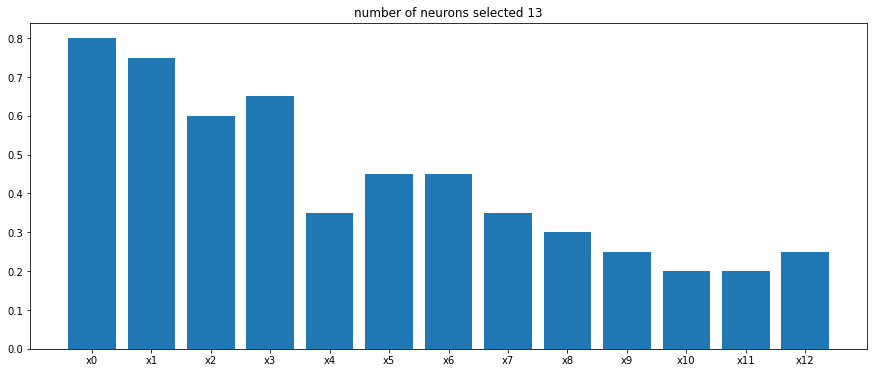

In [ ]:
neurons_loadings_thld = neurons_loadings[ neurons_loadings >= loadings_thld ]

plt.bar(neurons_loadings_thld.index, neurons_loadings_thld)
plt.title(f'number of neurons selected {neurons_loadings_thld.shape[0]}')

#Loadings and Variance Ratio

In [ ]:
def sofmax_(arr):
    exp_ = np.exp( arr )
    return exp_ / np.sum(exp_)

In [ ]:
# neurons_loadings_var = sofmax_(neurons_loadings * pca_cls.explained_variance_ratio_) * 100
neurons_loadings_var = neurons_loadings * pca_cls.explained_variance_ratio_
neurons_loadings_var

x0     0.115288
x1     0.096834
x2     0.060098
x3     0.057711
x4     0.024963
x5     0.029296
x6     0.023560
x7     0.015460
x8     0.010016
x9     0.007135
x10    0.005094
x11    0.004086
x12    0.004475
x13    0.002306
x14    0.000704
x15    0.000611
x16    0.000536
x17    0.000528
x18    0.001027
x19    0.000000
x20    0.000000
x21    0.000000
x22    0.000000
x23    0.000000
x24    0.000000
x25    0.000000
x26    0.000000
x27    0.000000
x28    0.000000
x29    0.000000
x30    0.000000
x31    0.000000
x32    0.000000
x33    0.000000
x34    0.000000
x35    0.000000
x36    0.000000
x37    0.000000
x38    0.000000
x39    0.000000
dtype: float64

Text(0.5, 1.0, 'number of neurons selected 4')

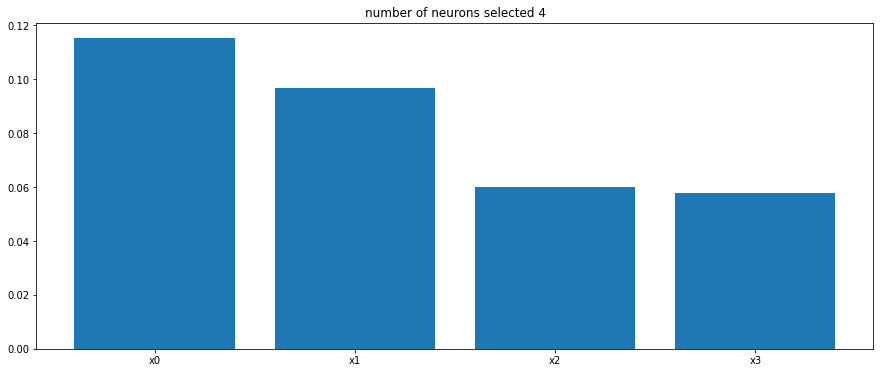

In [ ]:
loadings_var_thld = 0.2 * 0.2

neurons_loadings_var_thld = neurons_loadings_var[ neurons_loadings_var >= loadings_var_thld]


plt.bar(neurons_loadings_var_thld.index, neurons_loadings_var_thld)
plt.title(f'number of neurons selected {neurons_loadings_var_thld.shape[0]}')

#Loadings and Weights

In [ ]:
def get_neurons_based_weight(df, split_thld=0.005, weight=0.25):

    total_n = df.groupby('y').count()

    activations = df > split_thld
    activations['y'] = df['y']
    activations = activations.groupby('y').sum()
    activations = (activations / total_n) >= weight
    del total_n

    neurons = {}
    for i, row in activations.iterrows():
        neurons[i] =  set(df.columns[:-1][row])

    save_json(folder_path / 'neuron_weights.json', neurons)

    return neurons

In [ ]:
temp = get_neurons_based_weight(df)

In [ ]:
temp[1]

{'x0',
 'x10',
 'x13',
 'x15',
 'x17',
 'x23',
 'x25',
 'x3',
 'x31',
 'x37',
 'x5',
 'x6',
 'x9'}

In [ ]:
neurons_weights = (df_cls > 0.005).sum() / df_cls.count()

In [ ]:
neurons_weights_thld = neurons_weights[ neurons_weights>= 0.25]
neurons_weights_thld

x0     0.783945
x3     0.997341
x5     0.930364
x6     0.991524
x9     0.927372
x10    0.999834
x13    0.999335
x15    0.998504
x17    0.435101
x23    0.513046
x25    0.942496
x31    0.998006
x37    0.574206
dtype: float64

In [ ]:
 neurons_loadings_weights = neurons_weights * neurons_loadings

Text(0.5, 1.0, 'number of neurons selected 13')

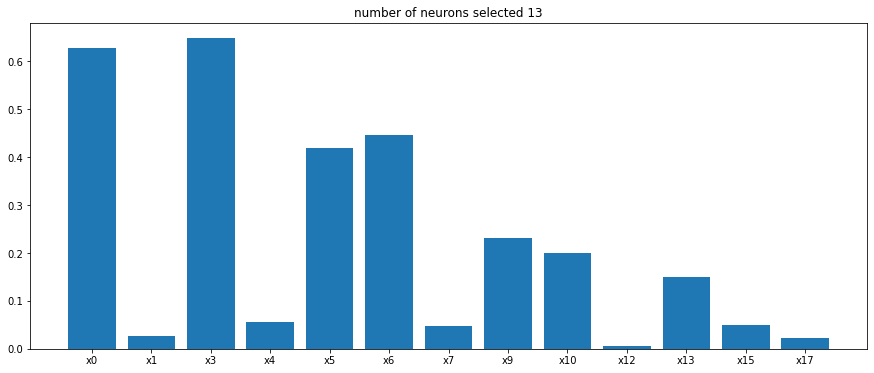

In [ ]:
loadings_weights_thld = 0.02 * 0.25

neurons_loadings_weights_thld = neurons_loadings_weights[ neurons_loadings_weights >= loadings_weights_thld]


plt.bar(neurons_loadings_weights_thld.index, neurons_loadings_weights_thld)
plt.title(f'number of neurons selected {neurons_loadings_weights_thld.shape[0]}')

In [ ]:
# are the loadings and loadings_weights neurons the same?
set(neurons_loadings_thld.index) | set(neurons_weights_thld.index) == set(neurons[1]) | temp[1]

True

In [ ]:
!zip -r MNIST_WITHOUT_BN_PCA.zip ./pca

updating: pca/ (stored 0%)
  adding: pca/pca_components/ (stored 0%)
  adding: pca/pca_components/pca_components_7.csv (deflated 52%)
  adding: pca/pca_components/pca_components_4.csv (deflated 52%)
  adding: pca/pca_components/pca_components_8.csv (deflated 52%)
  adding: pca/pca_components/pca_components_2.csv (deflated 52%)
  adding: pca/pca_components/pca_components_3.csv (deflated 52%)
  adding: pca/pca_components/pca_components_6.csv (deflated 52%)
  adding: pca/pca_components/pca_components_9.csv (deflated 52%)
  adding: pca/pca_components/pca_components_5.csv (deflated 52%)
  adding: pca/pca_components/pca_components_0.csv (deflated 52%)
  adding: pca/pca_components/pca_components_1.csv (deflated 52%)
  adding: pca/scaler.pkl (deflated 20%)
  adding: pca/neurons.json (deflated 93%)
  adding: pca/pca.pkl (deflated 6%)
  adding: pca/pca_6_scaled.csv (deflated 54%)
  adding: pca/pca_7_scaled.csv (deflated 54%)
  adding: pca/pca_1_scaled.csv (deflated 54%)
  adding: pca/pca_9_scale

#Loadings, Variance Ratio, and Weights

In [ ]:
loadings_var_weights_thld = 0.2 * 0.2 * 0.25

neurons_loadings_var_weights = neurons_loadings_weights * pca_cls.explained_variance_ratio_

In [ ]:
neurons_loadings_var_weights_thld = neurons_loadings_var_weights[ neurons_loadings_var_weights >= loadings_var_weights_thld ]

Text(0.5, 1.0, 'number of neurons selected 4')

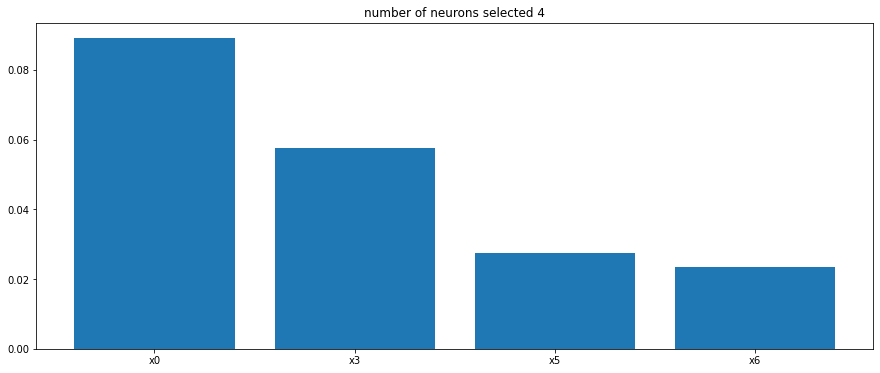

In [ ]:
plt.bar(neurons_loadings_var_weights_thld.index, neurons_loadings_var_weights_thld)
plt.title(f'number of neurons selected {neurons_loadings_var_weights_thld.shape[0]}')